In [ ]:
# # Standardized Precipitation Index (SPI) Forecasting Using LSTM
# This notebook demonstrates how to forecast SPI values using an LSTM model with scheduled sampling and recursive forecasting.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet  # optional, not used in this notebook
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import time
from scipy.stats import gamma, norm

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Step 1: Load and Prepare Data
#Read and preprocess the input data


In [ ]:
df = pd.read_csv("../result/merged_data.csv")
df['data'] = pd.to_datetime(df['data'])
df['month'] = df['data'].dt.to_period('M')
df = df.sort_values(by=['station_id', 'data'])
df.head()
# Group by station and month, summing precipitation
monthly_precip = df.groupby(['station_id', 'month'])['rrr24'].sum().reset_index()
monthly_precip['month'] = monthly_precip['month'].dt.to_timestamp()
monthly_precip.rename(columns={'month': 'ds', 'rrr24': 'precip'}, inplace=True)
# monthly_precip.head()


C:\Users\varas\AppData\Local\Temp\ipykernel_4136\1525420762.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data'] = pd.to_datetime(df['data'])


,station_id,ds,precip
0,40700,1990-01-01,29.90
1,40700,1990-02-01,11.90
2,40700,1990-03-01,9.82
3,40700,1990-04-01,94.42
4,40700,1990-05-01,39.53


Step 2: Compute SPI (Standardized Precipitation Index)


In [20]:
def compute_spi(precip_series):
    precip_array = precip_series.values
    nonzero = precip_array[precip_array > 0]

    if len(nonzero) == 0:
        return np.full_like(precip_array, np.nan, dtype=float)

    # Fit gamma distribution to non-zero data
    shape, loc, scale_param = gamma.fit(nonzero, floc=0)

    # Zero probability
    zero_prob = (precip_array == 0).sum() / len(precip_array)

    # Compute SPI values
    spi_values = np.full_like(precip_array, np.nan, dtype=float)
    for i, val in enumerate(precip_array):
        if np.isnan(val):
            continue
        if val == 0:
            prob = zero_prob
        else:
            prob = zero_prob + (1 - zero_prob) * gamma.cdf(val, shape, loc, scale_param)
        # Clip to avoid extreme ppf values at 0 or 1
        prob = np.clip(prob, 1e-10, 1 - 1e-10)
        spi_values[i] = norm.ppf(prob)

    return spi_values

def compute_spi_timescales(data, col='rrr24', timescales=[1, 3, 6, 9, 12, 24]):
    spi_results = {}
    
    # for scale in timescales:
    for scale in [12]:
        # Rolling precipitation over the given scale
        rolling_precip = data[col].rolling(scale, min_periods=scale).sum()

        # Compute SPI for the rolling sum
        spi_array = compute_spi(rolling_precip)

        # Assign back to a DataFrame aligned with original index
        spi_series = pd.Series(spi_array, index=data.index, name=f"SPI_{scale}")
        spi_results[f"SPI_{scale}"] = spi_series

    return pd.DataFrame(spi_results)

all_spi_data = {}

# for station_id in monthly_precip['station_id'].unique():
for station_id in [40708]:
    station_data = monthly_precip[monthly_precip['station_id'] == station_id].copy()
    station_data = station_data.sort_values('ds').reset_index(drop=True)

    spi_df = compute_spi_timescales(station_data, col='precip')
    combined = pd.concat([station_data[['ds']], spi_df], axis=1)
    
    all_spi_data[station_id] = combined


Step 3: Data Preparation for LSTM

Drop NaNs and scale the SPI series


In [21]:

# Create input/output sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

def prepare_all_sequences(all_spi_data, window_size=12):
    all_data = {}

    for station_id, spi_df in all_spi_data.items():
        station_result = {}

        for col in spi_df.columns:
            if not col.startswith('SPI_'):
                continue

            # Drop NaNs
            spi_series = spi_df[col].dropna().values.reshape(-1, 1)
            if len(spi_series) <= window_size:
                continue  # Not enough data

            # Normalize (z-score)
            scaler = StandardScaler()
            spi_scaled = scaler.fit_transform(spi_series)

            # Create input-output sequences
            X, y = create_sequences(spi_scaled, window_size)

            # Scheduled sampling input (optional)
            train_size = int(len(spi_scaled) * 0.8)
            train_seq = spi_scaled[:train_size + window_size]
            input_seq = torch.tensor(train_seq[:window_size].reshape(1, window_size, 1), dtype=torch.float32)
            target_seq = torch.tensor(train_seq[window_size:], dtype=torch.float32)

            # Store results
            station_result[col] = {
                'X': X,
                'y': y,
                'scaler': scaler,
                'input_seq': input_seq,
                'target_seq': target_seq
            }

        if station_result:
            all_data[station_id] = station_result

    return all_data


window_size = 12
prepared_data = prepare_all_sequences(all_spi_data, window_size)


Step 4: Define LSTM Models


In [22]:
class StackedLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(StackedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# model = StackedLSTMModel(input_size=1, hidden_size=64, num_layers=2, dropout=0.2)
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Step 5: Scheduled Sampling Training


In [23]:
def train_with_scheduled_sampling(model, input_seq, target_seq, optimizer, loss_fn, 
                                  epochs=150, initial_teacher_forcing_ratio=1.0, 
                                  min_teacher_forcing_ratio=0.1, decay=0.98):
    model.train()
    forecast_horizon = target_seq.size(0)
    for epoch in range(epochs):
        optimizer.zero_grad()
        teacher_forcing_ratio = max(initial_teacher_forcing_ratio * (decay ** epoch), min_teacher_forcing_ratio)
        current_input = input_seq.clone()
        outputs = []
        for t in range(forecast_horizon):
            pred = model(current_input)
            outputs.append(pred)
            if np.random.rand() < teacher_forcing_ratio:
                next_val = target_seq[t].view(1, 1, 1)
            else:
                next_val = pred.view(1, 1, 1)
            current_input = torch.cat([current_input[:, 1:, :], next_val], dim=1)
        outputs = torch.cat(outputs, dim=0)
        loss = loss_fn(outputs, target_seq)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Teacher Forcing Ratio: {teacher_forcing_ratio:.2f}")

# train_with_scheduled_sampling(model, input_seq, target_seq, optimizer, loss_fn, epochs=150)


In [30]:

def train_and_forecast(spi_data, model_params, training_params, forecast_steps, station_id, timescale):
    # Extract required components
    X = spi_data['X']
    y = spi_data['y']
    scaler = spi_data['scaler']
    input_seq = spi_data['input_seq']
    target_seq = spi_data['target_seq']
    
    # Initialize model
    model = StackedLSTMModel(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=training_params['lr'])
    loss_fn = nn.MSELoss()
    
    # Scheduled sampling training
    train_with_scheduled_sampling(
        model, input_seq, target_seq, optimizer, loss_fn,
        epochs=training_params['epochs'],
        initial_teacher_forcing_ratio=training_params['initial_teacher_forcing_ratio'],
        min_teacher_forcing_ratio=training_params['min_teacher_forcing_ratio'],
        decay=training_params['decay']
    )

    train_split = int(0.8 * len(X))
    X_train, X_test = X[:train_split], X[train_split:]
    y_train, y_test = y[:train_split], y[train_split:]

    # Train the model in one-step mode for comparison if desired:
    # (Note: this loop is separate from scheduled sampling training.)
    model.eval()
    for epoch in range(150):
        model.train()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"One-step Training Epoch {epoch}, Loss: {loss.item():.4f}")


    # Forecast future values
    last_sequence = scaler.transform(y[-training_params['window_size']:].reshape(-1, 1))
    current_seq = torch.tensor(last_sequence.reshape(1, training_params['window_size'], 1), dtype=torch.float32)

    predicted_future = []
    model.eval()
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_val = model(current_seq)
            predicted_future.append(next_val.item())
            new_seq = np.append(current_seq.numpy().squeeze(0)[1:], [[next_val.item()]], axis=0)
            current_seq = torch.tensor(new_seq.reshape(1, training_params['window_size'], 1), dtype=torch.float32)

    # Inverse transform
    future_predictions_scaled = np.array(predicted_future).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions_scaled)
    
    return future_predictions


In [25]:
def plot_spi_forecast(spi_df, predictions, forecast_steps, station_id, timescale):
    last_date = pd.to_datetime(spi_df['ds'].dropna().iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    plt.figure(figsize=(12, 6))
    plt.plot(spi_df['ds'], spi_df[timescale], label="Observed SPI", color='blue')
    plt.plot(future_dates, predictions, label=f"Forecast {timescale}", color='green')
    plt.axhline(-1, color='orange', linestyle='--', label='Moderate Drought')
    plt.axhline(-1.5, color='red', linestyle='--', label='Severe Drought')
    plt.axhline(-2, color='purple', linestyle='--', label='Extreme Drought')
    plt.title(f"{timescale} Forecast for Station {station_id}")
    plt.xlabel("Date")
    plt.ylabel("SPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"forecast_station{station_id}_{timescale}_{int(time.time())}.png")
    plt.show()



Training for Station 40708 - SPI_12
Epoch 0 | Loss: 1.1053 | Teacher Forcing Ratio: 1.00
Epoch 10 | Loss: 0.3811 | Teacher Forcing Ratio: 0.82
Epoch 20 | Loss: 0.3037 | Teacher Forcing Ratio: 0.67
Epoch 30 | Loss: 0.4127 | Teacher Forcing Ratio: 0.55
Epoch 40 | Loss: 0.4316 | Teacher Forcing Ratio: 0.45
Epoch 50 | Loss: 0.4449 | Teacher Forcing Ratio: 0.36
Epoch 60 | Loss: 0.8777 | Teacher Forcing Ratio: 0.30
Epoch 70 | Loss: 1.0092 | Teacher Forcing Ratio: 0.24
Epoch 80 | Loss: 0.7201 | Teacher Forcing Ratio: 0.20
Epoch 90 | Loss: 0.7635 | Teacher Forcing Ratio: 0.16
Epoch 100 | Loss: 0.7176 | Teacher Forcing Ratio: 0.13
Epoch 110 | Loss: 0.8440 | Teacher Forcing Ratio: 0.11
Epoch 120 | Loss: 0.9900 | Teacher Forcing Ratio: 0.10
Epoch 130 | Loss: 1.3440 | Teacher Forcing Ratio: 0.10
Epoch 140 | Loss: 1.1197 | Teacher Forcing Ratio: 0.10
One-step Training Epoch 0, Loss: 0.7823
One-step Training Epoch 10, Loss: 0.4546
One-step Training Epoch 20, Loss: 0.2929
One-step Training Epoch 30,

C:\Users\varas\AppData\Local\Temp\ipykernel_4136\3949470704.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


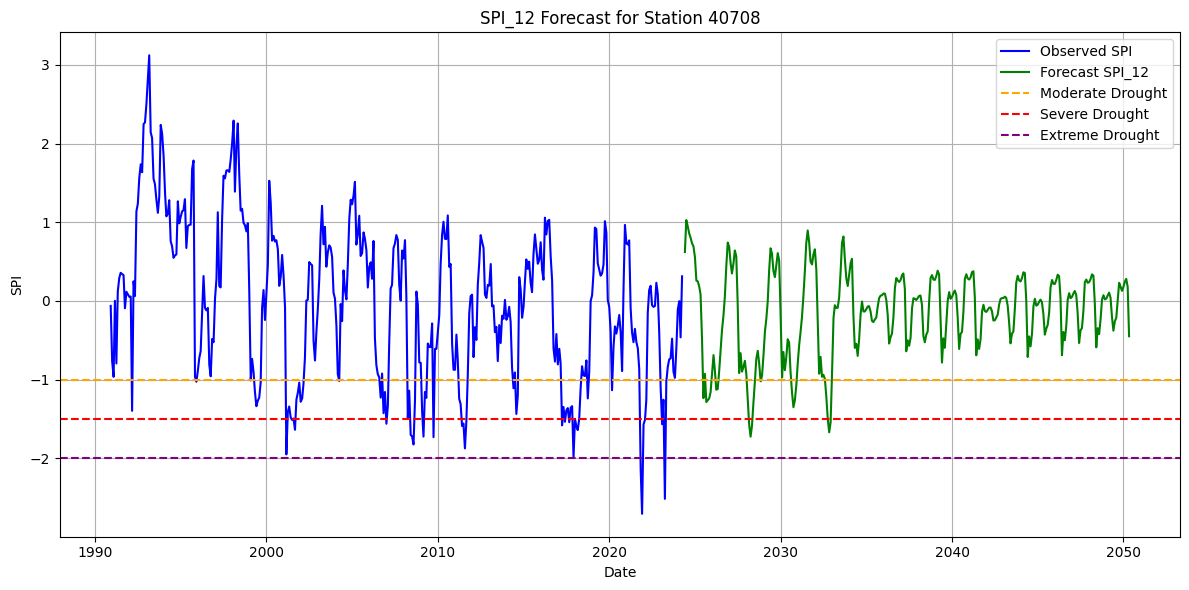

In [31]:
model_params = {
    'input_size': 1,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2
}

training_params = {
    'lr': 0.01,
    'epochs': 150,
    'window_size': 12,
    'initial_teacher_forcing_ratio': 1.0,
    'min_teacher_forcing_ratio': 0.1,
    'decay': 0.98
}

forecast_steps = 312 # 26 years of monthly data

for station_id, timescale_data in prepared_data.items():
    for timescale, spi_data in timescale_data.items():
        print(f"\nTraining for Station {station_id} - {timescale}")
        try:
            forecast = train_and_forecast(
                spi_data, model_params, training_params,
                forecast_steps, station_id, timescale
            )
            plot_spi_forecast(all_spi_data[station_id], forecast, forecast_steps, station_id, timescale)
        except Exception as e:
            print(f"Error in station {station_id}, {timescale}: {e}")
